In [1]:
!pip3 install holidays==0.24
!pip3 install prophet==1.1.2

You should consider upgrading via the '/home/ubuntu/.pyenv/versions/3.8.10/envs/venv3810/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ubuntu/.pyenv/versions/3.8.10/envs/venv3810/bin/python3.8 -m pip install --upgrade pip' command.


# Initialize all data structures

In [2]:
import pandas as pd
df = pd.read_csv("data/upc_sales.csv")

# Stores
df_stores = pd.read_csv("data/stores.csv")

# DEMO data
df["DATE"] = pd.to_datetime(df["DATE"])
df["WEEK"] = df['DATE'].dt.to_period('W').dt.to_timestamp()

df = pd.merge(df, df_stores, left_on="STOREID", right_on="STORE_ID", how="inner")
df.rename(columns={"RETAILER_ID_x":"RETAILER_ID", "CITY":"PPG"},inplace=True)
df.drop(columns=["RETAILER_ID_y","STORE_NAME","STORE_ID"],inplace=True)

# Group
df_grouped_volume = df.groupby(["UPC","RETAILER_ID","PPG","WEEK"]).agg(
    {"qty":"sum","mean_unit_price_rounded":"mean"}).reset_index()

df_grouped_volume.rename(columns={"mean_unit_price_rounded":"mean_unit_price"},inplace=True)
df_grouped_volume.set_index("WEEK",inplace=True)


# UPC list
df_use_case_upcs = pd.read_csv("data/input_upcs - synthetic-usecases.csv")

print(f"No of columns in DEMO --> {len(df.columns)}")


No of columns in DEMO --> 9


# INPUT UPC

In [3]:
MYUPC = 987654321

In [4]:
import numpy as np

df_use_cases_upcs_current = df_use_case_upcs[df_use_case_upcs["UPC"]==MYUPC]
RETAILER_ID = df_use_cases_upcs_current["RETAILER_ID"].values[0]
PPG = df_use_cases_upcs_current["PPG"].values[0]

print(f"Retailer --> {RETAILER_ID}, PPG --> {PPG}")

df_upc_grouped = df_grouped_volume[(df_grouped_volume["UPC"]==MYUPC)
                           &(df_grouped_volume["RETAILER_ID"]==RETAILER_ID)
                           &(df_grouped_volume["PPG"]==PPG)]

df_upc = df_upc_grouped[["qty","mean_unit_price"]]

df_upc_prophet = df_upc_grouped[["qty","mean_unit_price"]]
df_upc_prophet.loc[:,"WEEK"] = df_upc_prophet.index
df_upc_prophet.rename(columns={"qty":"y","WEEK":"ds"},inplace=True)

df_upc = df_upc.asfreq('W',method="ffill") #prophet can deal with missing

df_upc["Logqty"] = np.log(df_upc["qty"])

# df.index = df.index.to_timestamp(freq="D")

# df_upc.loc[:,"WEEK"] = df_upc.index


df_upc

Retailer --> 3, PPG --> COLUMBIA


/tmp/ipykernel_902785/3565680145.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upc_prophet.loc[:,"WEEK"] = df_upc_prophet.index
/tmp/ipykernel_902785/3565680145.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upc_prophet.rename(columns={"qty":"y","WEEK":"ds"},inplace=True)


,qty,mean_unit_price,Logqty
WEEK,,,
2017-01-01,15.0,4.000000,2.708050
2017-01-08,186.0,4.495413,5.225747
2017-01-15,196.0,4.598291,5.278115
2017-01-22,169.0,3.980392,5.129899
2017-01-29,169.0,3.967742,5.129899
...,...,...,...
2021-05-16,156.0,4.234568,5.049856
2021-05-23,101.0,4.295082,4.615121
2021-05-30,129.0,4.303797,4.859812


In [26]:
df_upc["mean_unit_price"].mode()

0    2.0
Name: mean_unit_price, dtype: float64

In [4]:
df_upc.index

DatetimeIndex(['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22',
               '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19',
               '2017-02-26', '2017-03-05',
               ...
               '2021-04-11', '2021-04-18', '2021-04-25', '2021-05-02',
               '2021-05-09', '2021-05-16', '2021-05-23', '2021-05-30',
               '2021-06-06', '2021-06-13'],
              dtype='datetime64[ns]', name='WEEK', length=233, freq='W-SUN')

In [5]:
from prophet import Prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet.plot import add_changepoints_to_plot

/home/ubuntu/.pyenv/versions/3.8.10/envs/venv3810/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Prophet hyper
- Default growth is `linear` (very rarely we have to change to `logistic` unless sure)
- Prophet can deal with missing values in time series (so no need to fill, in fact filling makes the model worse sometimes)
- Regressors can be additive or multiplicative (requires `prior evaluation`)
- Below is weekly frequency
- For `outliers`, generally exclude them is the best choice for Prophet

16:52:04 - cmdstanpy - INFO - Chain [1] start processing
16:52:04 - cmdstanpy - INFO - Chain [1] done processing


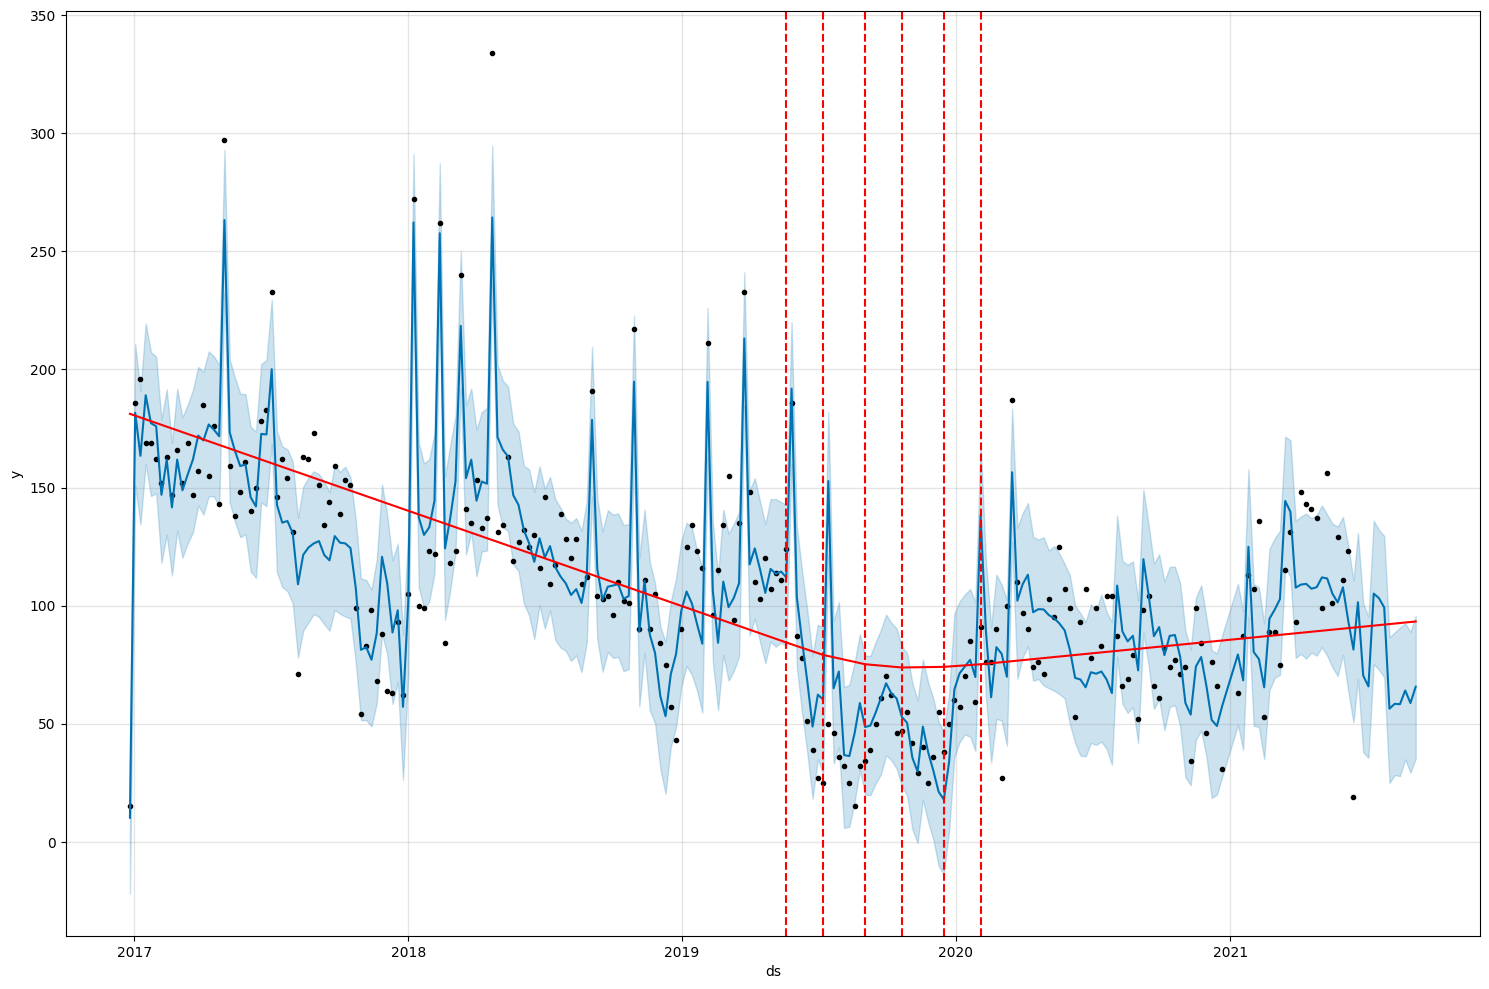

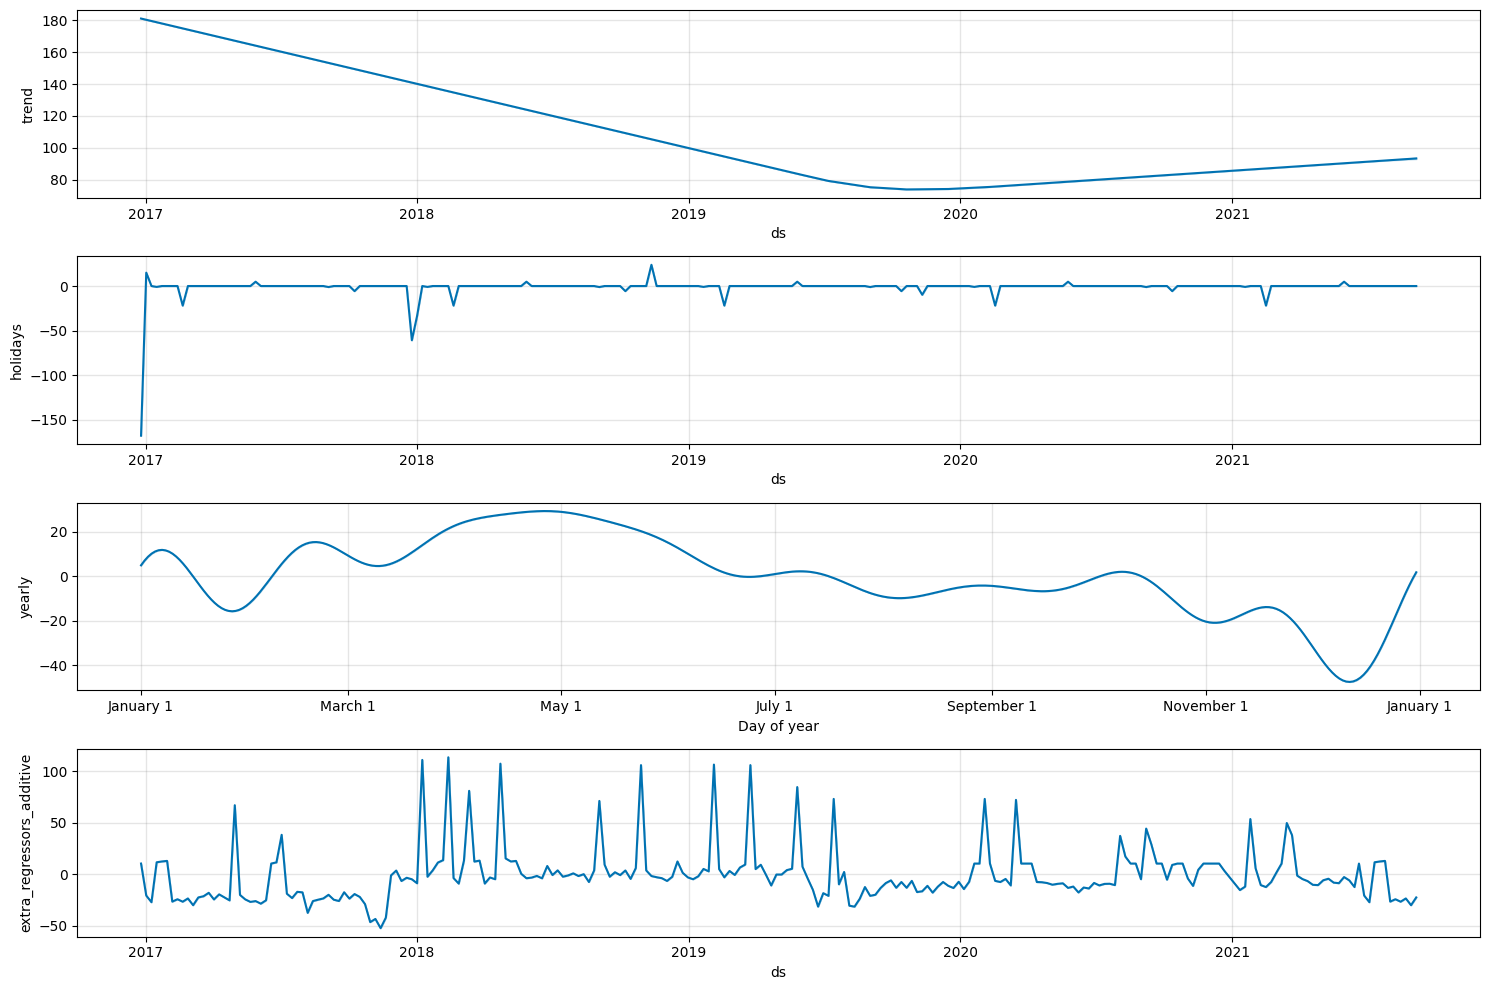

In [6]:
m1 = Prophet()
m1.add_country_holidays(country_name="US")
m1.add_regressor("mean_unit_price", mode="additive")
m1.fit(df_upc_prophet)

future1 =m1.make_future_dataframe(periods=12, freq="W")

# existing_plus_future_52_values = df_upc["mean_unit_price"].to_list() + df_upc["mean_unit_price"].to_list()[0:52] 
existing_plus_future_12_values = df_upc_prophet["mean_unit_price"].to_list() + df_upc_prophet["mean_unit_price"].to_list()[0:12]

future1.loc[:,"mean_unit_price"] = existing_plus_future_12_values
# print(future.head())
# print(future.tail())

forecast1 = m1.predict(future1)
# forecast.tail()


fig_forecast1 = m1.plot(forecast1, figsize=(15,10))

a = add_changepoints_to_plot(fig_forecast1.gca(), m1 , forecast1)

# Observe there is no weekly component
fig_components_forecast1 = m1.plot_components(forecast1, figsize=(15,10))


## Regressors
- Add extra regressors like `storeopen`, `promo`, `schoolholiday`
- For e.g. df_upc["open"] should contain 0 or 1 - which means store is open or close
- m.add_regressor("open", mode="multiplicative") - since 1 multiplied with the actual value gives us the same (additive changes the actual value)

16:52:20 - cmdstanpy - INFO - Chain [1] start processing
16:52:20 - cmdstanpy - INFO - Chain [1] done processing


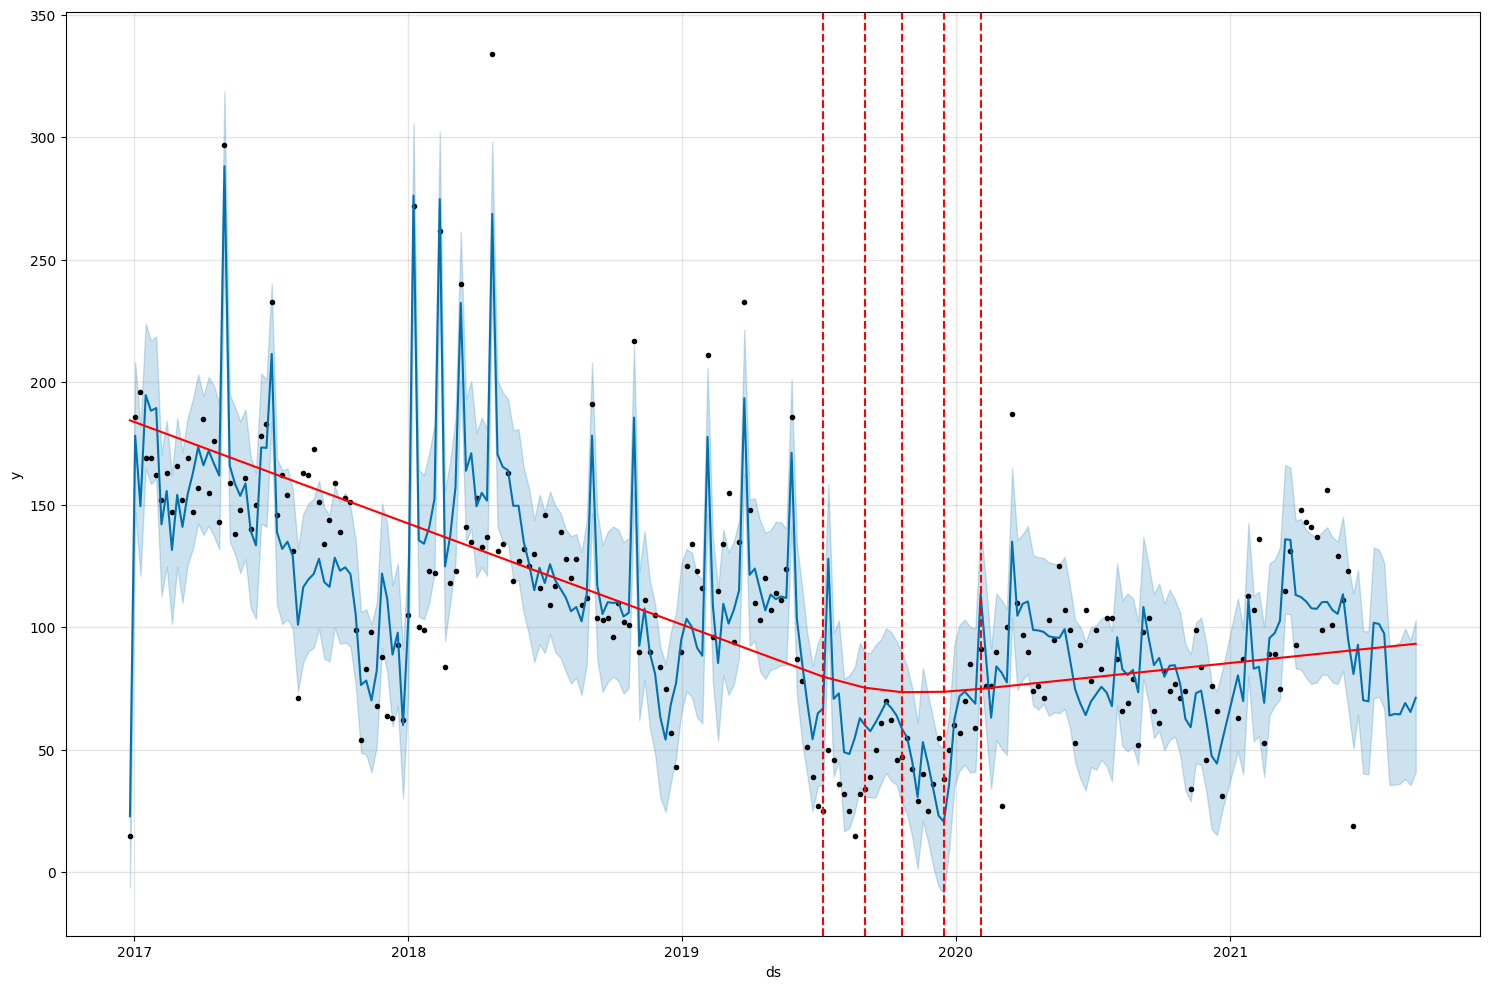

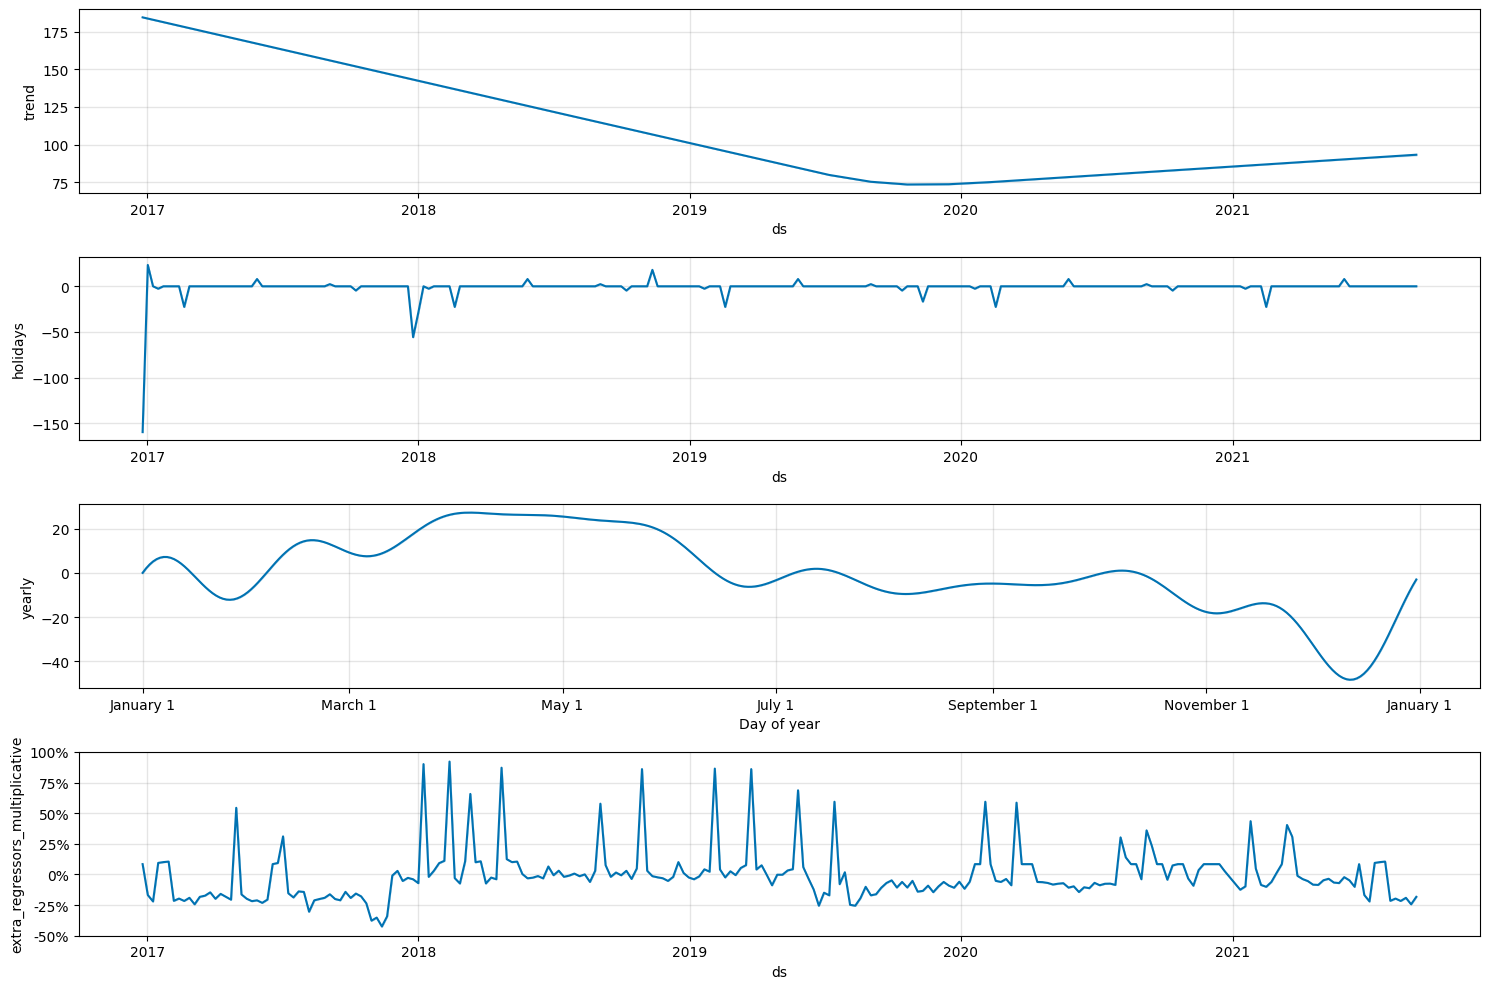

In [7]:
m2 = Prophet()
m2.add_country_holidays(country_name="US")

m2.add_regressor("mean_unit_price", mode="multiplicative")
m2.fit(df_upc_prophet)

future2 = m2.make_future_dataframe(periods=12, freq="W")

# existing_plus_future_52_values = df_upc["mean_unit_price"].to_list() + df_upc["mean_unit_price"].to_list()[0:52]
existing_plus_future_12_values = df_upc_prophet["mean_unit_price"].to_list() + df_upc_prophet["mean_unit_price"].to_list()[0:12]

future2.loc[:,"mean_unit_price"] = existing_plus_future_12_values
# print(future.head())
# print(future.tail())

forecast2 = m2.predict(future2)
# forecast.tail()


fig1_forecast2 = m2.plot(forecast2, figsize=(15,10))

a2 = add_changepoints_to_plot(fig1_forecast2.gca(), m2 , forecast2)

# Observe there is no weekly component
fig2_forecast2 = m2.plot_components(forecast2, figsize=(15,10))

In [8]:
forecast2[["ds","yearly","yhat"]].tail(20)

,ds,yearly,yhat
224,2021-04-26,26.066687,107.567101
225,2021-05-03,25.182110,110.283188
226,2021-05-10,23.976363,110.385550
227,2021-05-17,23.194055,107.052047
228,2021-05-24,21.837093,105.503280
229,2021-05-31,17.370535,113.527928
230,2021-06-07,8.891008,94.973998
231,2021-06-14,-0.555955,80.967995
232,2021-06-20,-5.582339,92.930871
233,2021-06-27,-5.544634,70.240726


In [9]:
forecast2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 73 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   ds                                                     244 non-null    datetime64[ns]
 1   trend                                                  244 non-null    float64       
 2   yhat_lower                                             244 non-null    float64       
 3   yhat_upper                                             244 non-null    float64       
 4   trend_lower                                            244 non-null    float64       
 5   trend_upper                                            244 non-null    float64       
 6   Christmas Day                                          244 non-null    float64       
 7   Christmas Day_lower                                    244 non-null    

## cross validation hyper parameters
- `initial` - number of training points
- `period` - step size
- `horizon` - number of steps to forecast

In [11]:
from prophet.diagnostics import cross_validation

df_cv_m1 = cross_validation(m1,initial="156 W",period="1 W", horizon="12 W")

df_cv_m2 = cross_validation(m2,initial="156 W",period="1 W", horizon="12 W")
df_cv_m2


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]16:53:22 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] done processing

  2%|█▎                                                                                 | 1/66 [00:00<00:12,  5.30it/s]16:53:22 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] done processing

  3%|██▌                                                                                | 2/66 [00:00<00:11,  5.44it/s]16:53:22 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] done processing

  5%|███▊                                                                               | 3/66 [00:00<00:11,  5.37it/s]16:53:22 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████                                                         

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-30,54.085985,26.454318,84.470494,60.0,2019-12-23
1,2020-01-06,63.943938,34.591691,94.705732,57.0,2019-12-23
2,2020-01-13,62.181446,33.852556,91.589051,70.0,2019-12-23
3,2020-01-20,37.548621,8.137940,66.785551,85.0,2019-12-23
4,2020-01-27,40.553248,13.844048,68.869980,59.0,2019-12-23
...,...,...,...,...,...,...
763,2021-05-17,95.012493,67.140218,123.189464,101.0,2021-03-22
764,2021-05-24,91.695998,60.784202,120.174602,129.0,2021-03-22
765,2021-05-31,109.273496,79.707084,136.024207,111.0,2021-03-22
766,2021-06-07,89.185374,61.952287,118.444037,123.0,2021-03-22


### Understanding output of CV
- `ds`: date the forecast is for
- `cutoff`: date from which forecast is made


In [12]:
df_cv_m2.head(24)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-30,54.085985,26.454318,84.470494,60.0,2019-12-23
1,2020-01-06,63.943938,34.591691,94.705732,57.0,2019-12-23
2,2020-01-13,62.181446,33.852556,91.589051,70.0,2019-12-23
3,2020-01-20,37.548621,8.137940,66.785551,85.0,2019-12-23
4,2020-01-27,40.553248,13.844048,68.869980,59.0,2019-12-23
5,2020-02-03,70.579986,42.231500,100.625684,91.0,2019-12-23
6,2020-02-10,56.688379,28.586567,86.976161,76.0,2019-12-23
7,2020-02-17,39.753334,11.965842,68.520709,76.0,2019-12-23
8,2020-02-24,66.454590,37.094894,96.765340,90.0,2019-12-23
9,2020-03-02,62.776144,33.571777,93.392254,27.0,2019-12-23


### Moving average is behind the metrics
- Window size is 10% of horizon (so 10% of 12 weeks = 2 weeks)

In [13]:
from prophet.diagnostics import performance_metrics
pm1 = performance_metrics(df_cv_m1)
pm2 = performance_metrics(df_cv_m2)
pm2

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,14 days,898.834230,29.980564,23.616753,0.284039,0.248815,0.309683,0.639803
1,21 days,986.555527,31.409481,24.987644,0.291593,0.289125,0.324339,0.611842
2,28 days,1059.420438,32.548739,26.022523,0.299758,0.296779,0.336418,0.583059
3,35 days,1064.029616,32.619467,25.969045,0.294295,0.314256,0.331452,0.564967
4,42 days,1082.527551,32.901786,25.986831,0.291552,0.299917,0.330746,0.575658
5,49 days,1136.678593,33.714664,26.377227,0.291927,0.303090,0.335412,0.564967
6,56 days,1173.853288,34.261542,26.595004,0.293051,0.296552,0.338935,0.549342
7,63 days,1215.308119,34.861270,27.081224,0.294426,0.293534,0.342661,0.546875
8,70 days,1254.252773,35.415431,27.568184,0.299917,0.294007,0.351468,0.546875
9,77 days,1277.393285,35.740639,27.686959,0.284002,0.292057,0.347119,0.560033


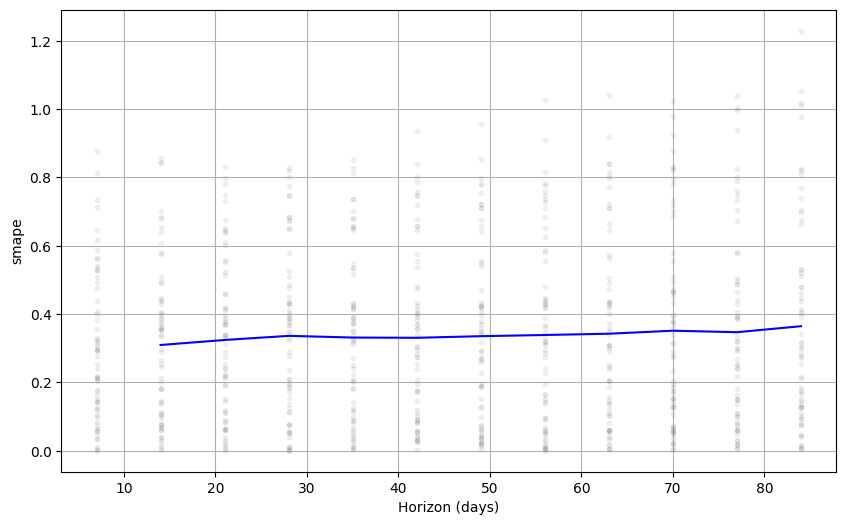

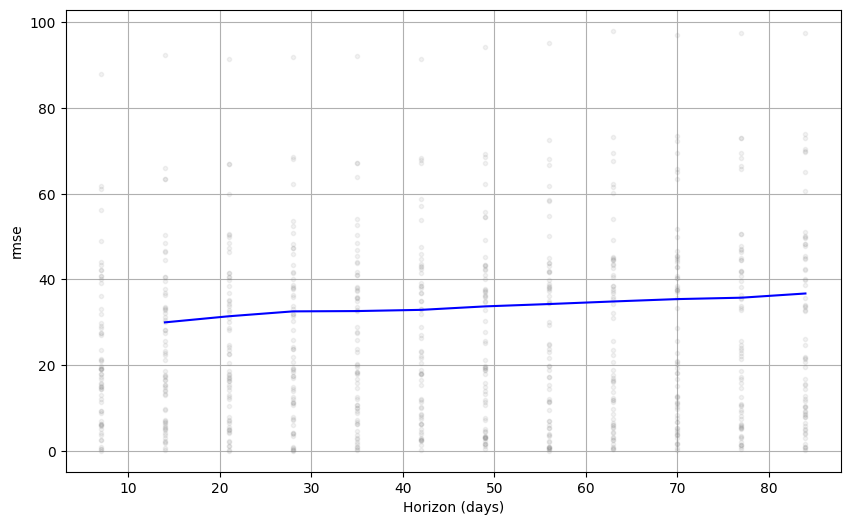

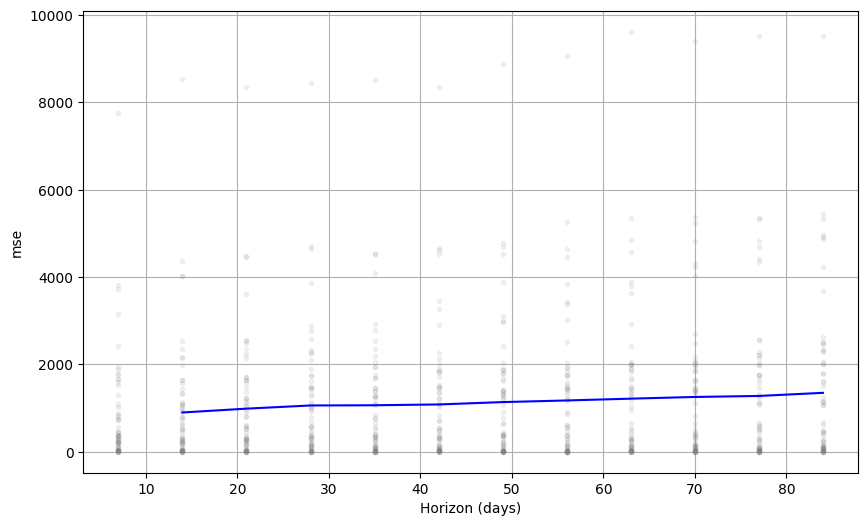

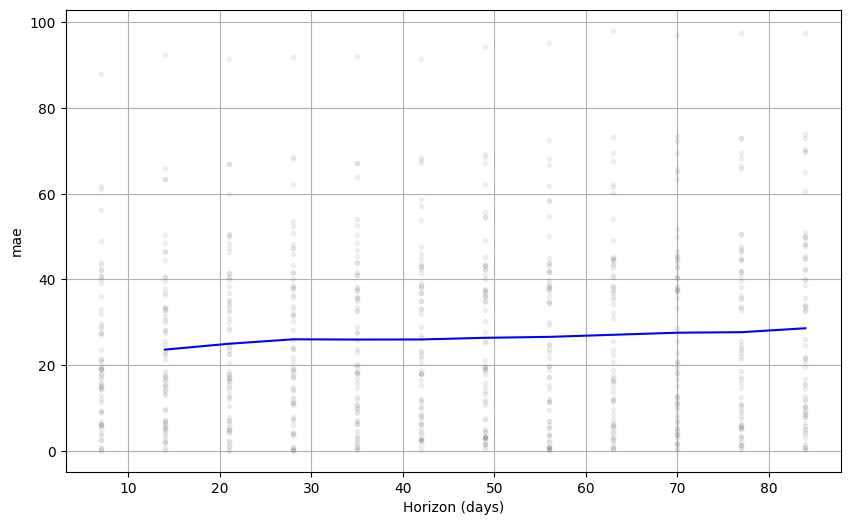

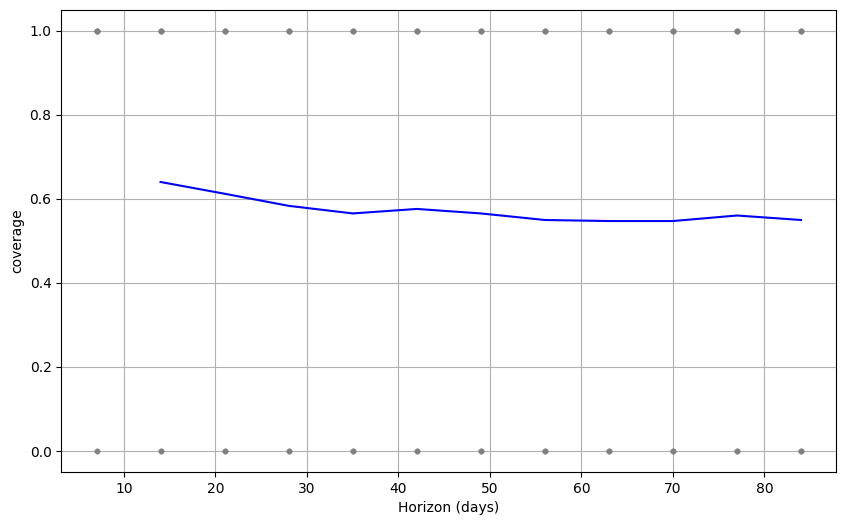

In [14]:
from prophet.plot import plot_cross_validation_metric

fig_smape = plot_cross_validation_metric(df_cv_m2, metric="smape")
fig_rmse = plot_cross_validation_metric(df_cv_m2, metric="rmse")
fig_mse = plot_cross_validation_metric(df_cv_m2, metric="mse")
fig_mae = plot_cross_validation_metric(df_cv_m2, metric="mae")
fig_coverage = plot_cross_validation_metric(df_cv_m2, metric="coverage")

## Evaluation
- Based on this model m1 (`additive` unit price regressor) is better statistically
- Lowest `smape` is better

In [15]:
print(pm2["smape"].mean())
print(pm1["smape"].mean())

0.33753665676140654
0.37501077959259205


## ARIMA, SARIMAX & PROPHET

16:57:23 - cmdstanpy - INFO - Chain [1] start processing
16:57:23 - cmdstanpy - INFO - Chain [1] done processing
/home/ubuntu/.pyenv/versions/3.8.10/envs/venv3810/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82372D+00    |proj g|=  5.63861D-02

At iterate    5    f=  3.80291D+00    |proj g|=  4.53088D-03

At iterate   10    f=  3.80066D+00    |proj g|=  7.79950D-03

At iterate   15    f=  3.79528D+00    |proj g|=  1.32904D-03

At iterate   20    f=  3.79386D+00    |proj g|=  2.53241D-02

At iterate   25    f=  3.79141D+00    |proj g|=  4.33808D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     31      1     0     0   

 95%|██████████████████████████████████████████████████████████████████████████████▎   | 63/66 [05:54<00:16,  5.63s/it]


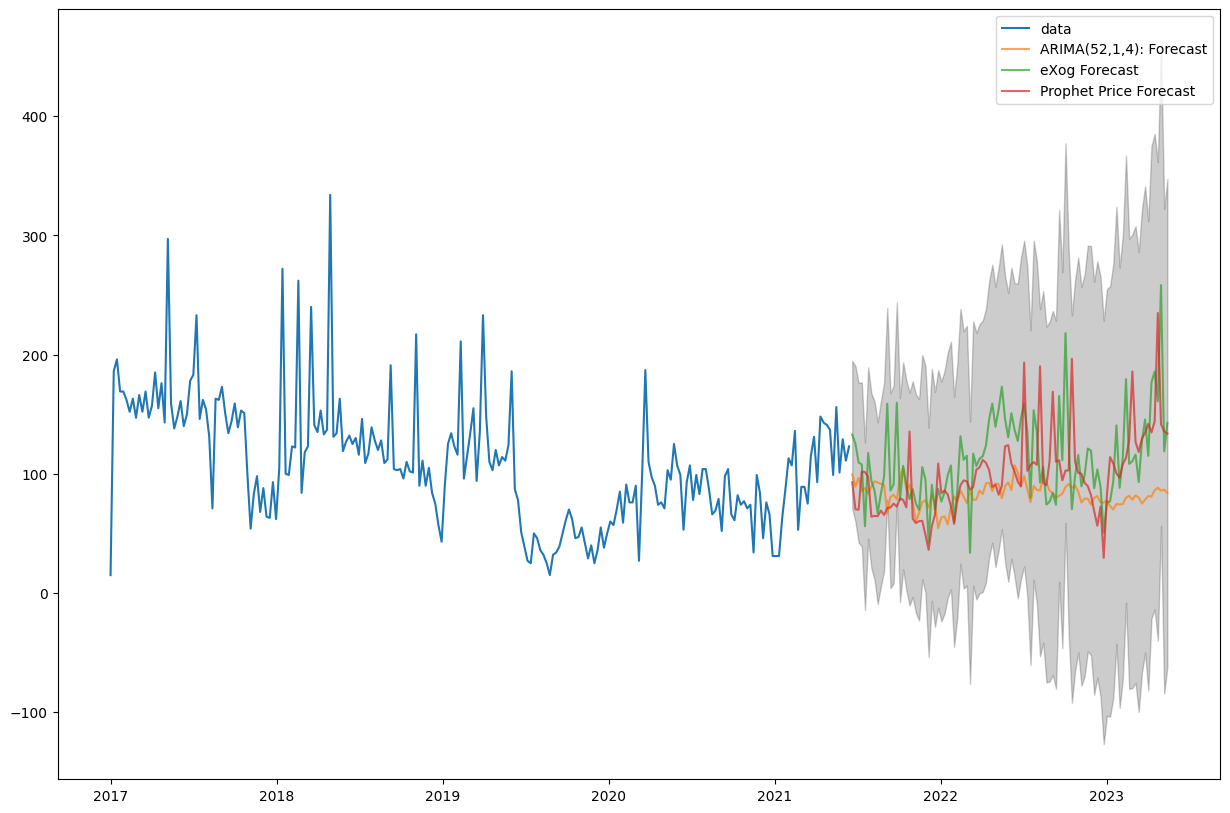

In [17]:
from prophet import Prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet.plot import add_changepoints_to_plot
import statsmodels.api as sm

FORECAST_STEPS = 100
FORECAST_START = "2021-06-20"
FORECAST_END = "2023-05-14"


# PROPHET

m1 = Prophet()
m1.add_country_holidays(country_name="US")
m1.add_regressor("mean_unit_price", mode="multiplicative")
m1.fit(df_upc_prophet)

future1 =m1.make_future_dataframe(periods=FORECAST_STEPS, freq="W",include_history=False)

# existing_plus_future_52_values = df_upc["mean_unit_price"].to_list() + df_upc["mean_unit_price"].to_list()[0:52] 
# existing_plus_future_100_values = df_upc_prophet["mean_unit_price"].to_list() + df_upc_prophet["mean_unit_price"].to_list()[0:100]

future1.loc[:,"mean_unit_price"] = df_upc_prophet["mean_unit_price"].to_list()[0:100]

forecast1 = m1.predict(future1)
forecast1["ds"]

## ARIMA 

from statsmodels.tsa.arima.model import ARIMA



Ntest = 12
train = df_upc.iloc[:-Ntest]
test = df_upc.iloc[-Ntest:]

train_idx = df_upc.index <= train.index[-1]
test_idx = df_upc.index > train.index[-1]

arima = ARIMA(train["Logqty"], order=(52,1,4))
arima_result_log5214 = arima.fit()

# predict_arima_result_log5214 = arima_result_log5214.get_forecast(FORECAST_STEPS)
predict_arima_result_log5214 = arima_result_log5214.get_prediction(start=FORECAST_START, end=FORECAST_END)



## SARIMAX EXOG

exog_mod = sm.tsa.statespace.SARIMAX(df_upc["qty"],exog=df_upc["mean_unit_price"],
                                order=(1,1,1),
                                seasonal_order=(1,1,0,52),)

exog_results = exog_mod.fit()

# Performance metrics
print("MSE: ", exog_results.mse)
print("AIC: ", exog_results.aic)
print("SSE: ", exog_results.sse)

exog_forecast_prices = df_upc["mean_unit_price"].sample(FORECAST_STEPS).to_list()
exog_forecast_prices

exog_results.get_prediction()

# exog_pred = exog_results.get_forecast(FORECAST_STEPS, exog=exog_forecast_prices)
exog_pred = exog_results.get_prediction(start=FORECAST_START, end=FORECAST_END, exog=exog_forecast_prices)
exog_pred_ci = exog_pred.conf_int()

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(df_upc["qty"].index, df_upc["qty"], label="data")

ax.plot(predict_arima_result_log5214.conf_int().index, np.exp(predict_arima_result_log5214.predicted_mean), 
        label='ARIMA(52,1,4): Forecast', alpha=.7)

ax.plot(exog_pred_ci.index, exog_pred.predicted_mean, label='eXog Forecast', alpha=.7)

ax.plot(forecast1["ds"], forecast1["yhat"], label='Prophet Price Forecast', alpha=.7)

ax.fill_between(exog_pred_ci.index,
                exog_pred_ci["lower qty"],
                exog_pred_ci["upper qty"], color='k', alpha=.2)



ax.legend()



In [18]:

import numpy as np
import pandas as pd

unit_price_list_before_reindex = df_upc_grouped["mean_unit_price"].to_list()

unioned_index = df_upc_grouped.index.union(exog_results.get_forecast(FORECAST_STEPS, exog=exog_forecast_prices).conf_int().index)
df_upc_grouped = df_upc_grouped.reindex(index=unioned_index)

df_upc_grouped["SARIMAX forecasted"] = exog_results.get_forecast(FORECAST_STEPS, exog=exog_forecast_prices).predicted_mean
df_upc_grouped["SARIMAX conf lower qty"] = exog_results.get_forecast(FORECAST_STEPS, exog=exog_forecast_prices).conf_int()["lower qty"]
df_upc_grouped["SARIMAX conf upper qty"] = exog_results.get_forecast(FORECAST_STEPS, exog=exog_forecast_prices).conf_int()["upper qty"]


arima_results_df = np.exp(arima_result_log5214.get_forecast(FORECAST_STEPS).predicted_mean)
arima_results_df = arima_results_df.reindex(unioned_index, fill_value=0)

df_upc_grouped["ARIMA log forecasted"] = np.exp(arima_result_log5214.get_forecast(
    FORECAST_STEPS).predicted_mean).reindex(unioned_index, fill_value=0)
df_upc_grouped["ARIMA log conf lower qty"] =  np.exp(arima_result_log5214.get_forecast(FORECAST_STEPS).conf_int()["lower Logqty"]).reindex(unioned_index, fill_value=0)
df_upc_grouped["ARIMA log conf upper qty"] = np.exp(arima_result_log5214.get_forecast(FORECAST_STEPS).conf_int()["upper Logqty"]).reindex(unioned_index, fill_value=0)


prophet_forecast_df = forecast1[["ds","yhat","yhat_lower","yhat_upper"]]
prophet_forecast_df.set_index("ds",inplace=True)

df_upc_grouped["Prophet forecasted"] = prophet_forecast_df["yhat"].reindex(unioned_index, fill_value=0)
df_upc_grouped["Prophet conf lower qty"] =  prophet_forecast_df["yhat_lower"].reindex(unioned_index, fill_value=0)
df_upc_grouped["Prophet conf upper qty"] = prophet_forecast_df["yhat_upper"].reindex(unioned_index, fill_value=0)



# Below is to fill price column in the final dataframe
df_upc_grouped["mean_unit_price"] = unit_price_list_before_reindex + exog_forecast_prices

df_upc_grouped["WEEK"] = df_upc_grouped.index.to_series()
# print(df_upc_grouped)
df_upc_grouped.to_csv("data/SAMPLE_ARIMA_SARIMAX_PROPHET_OUTPUT.csv", index=False)


## Correlation

In [19]:
print(f" SARIMAX vs. PROPHET CORR : {df_upc_grouped['SARIMAX forecasted'].corr(df_upc_grouped['Prophet forecasted'])}")

print(f" SARIMAX vs. ARIMA LOG CORR :{df_upc_grouped['SARIMAX forecasted'].corr(df_upc_grouped['ARIMA log forecasted'])}")

print(f" PROPHET vs. ARIMA LOG CORR :{df_upc_grouped['Prophet forecasted'].corr(df_upc_grouped['ARIMA log forecasted'])}")



 SARIMAX vs. PROPHET CORR : 0.3530922429922888
 SARIMAX vs. ARIMA LOG CORR :-0.25152179248257095
 PROPHET vs. ARIMA LOG CORR :0.7689929914250246
